# Imports

In [11]:
import os
import sys
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import flopy
from flopy.mf6.utils import Mf6Splitter

# print some inf
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.11.9 (main, Apr  2 2024, 13:43:44) [GCC 13.2.0]
numpy version: 1.26.3
matplotlib version: 3.9.2
flopy version: 3.9.2


# Paths and Simulation

In [3]:
# define paths and 
model_dir = "./model" 
sim_name = "mfsim.nam"
exe_name = "mf6"
output_dir = "./submodels"

# load the simulation
try:
    print(f"loading simulation from {model_dir}/{sim_name}...")
    base_sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, sim_ws=model_dir, exe_name=exe_name)
    base_gwf = base_sim.get_model()
    print("simulation loaded successfully")
except Exception as e:
    sys.exit(f"error loading simulation: {e}")


loading simulation from ./model/mfsim.nam...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package ghb...
    loading package npf...
    loading package sto...
    loading package hfb...
    loading package uzf...
  loading solution package rgtihm...
simulation loaded successfully


# Model Splitting
Split the model and write simulation

model DIS info:
 - layers: 9
 - rows: 912
 - columns: 328
idomain shape: (9, 912, 328)
total active cells (idomain == 1): 805886
Layer 1 active cells: 17879
Layer 2 active cells: 17879
Layer 3 active cells: 107959
Layer 4 active cells: 107959
Layer 5 active cells: 110244
Layer 6 active cells: 110244
Layer 7 active cells: 110573
Layer 8 active cells: 110573
Layer 9 active cells: 112576
pymetis is installed and imported successfully.
using METIS to split into 6 parts
error in METIS splitting: only integer scalar arrays can be converted to a scalar index
falling back to custom splitting
using custom splitting to split into 6 parts
Total stress periods: 898
Stress period 0: 34932 HFB barriers
Stress period 1: 34932 HFB barriers
Stress period 2: 34932 HFB barriers
Stress period 3: 34932 HFB barriers
Stress period 4: 34932 HFB barriers
Calculating for all stress periods...
Processing stress period 0/898
Processing stress period 100/898
Processing stress period 200/898
Processing stress perio

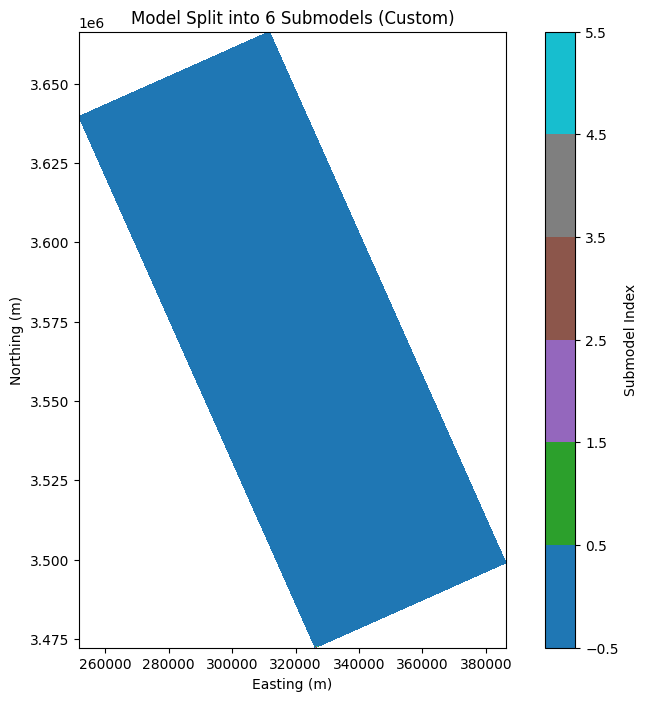

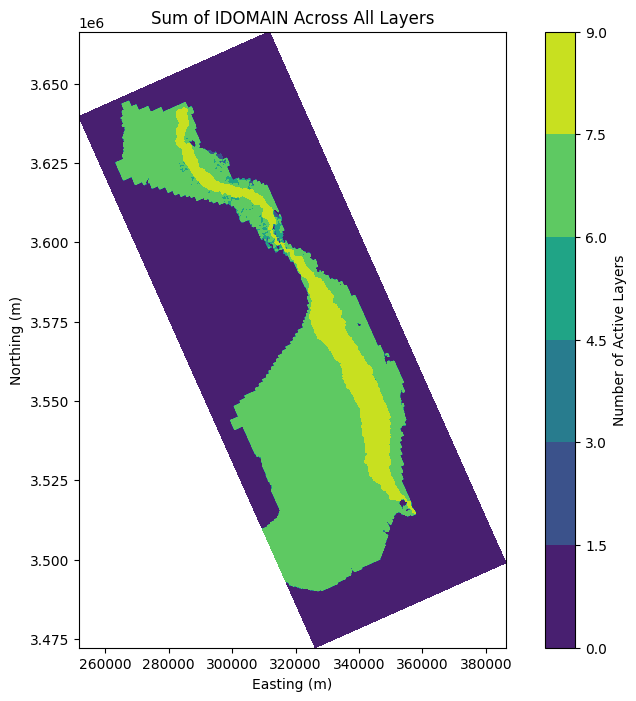

SystemExit: error splitting model: '[1, 2, 3, 4, 5] are not in the active model extent; please adjust the model splitting array'

In [30]:
import numpy as np
import shutil
import os
import sys
import matplotlib.pyplot as plt
from flopy.mf6.utils import Mf6Splitter
from scipy.ndimage import label

# Union-Find data structure for merging cells connected by HFB barriers
class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))
        self.rank = [0] * size
    
    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])  # path compression
        return self.parent[x]
    
    def union(self, x, y):
        px, py = self.find(x), self.find(y)
        if px == py:
            return
        # union by rank
        if self.rank[px] < self.rank[py]:
            px, py = py, px
        self.parent[py] = px
        if self.rank[px] == self.rank[py]:
            self.rank[px] += 1
    
    def get_groups(self):
        groups = {}
        for i in range(len(self.parent)):
            root = self.find(i)
            if root not in groups:
                groups[root] = []
            groups[root].append(i)
        return list(groups.values())

# define splitting settings
n_submodels = 6  # number of parts to split into (works with 2; adjust as needed)
output_dir = "./submodels"

# create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

# initialize splitter
mfsplit = Mf6Splitter(base_sim)

# print basic DIS info
print("model DIS info:")
print(f" - layers: {base_gwf.dis.nlay.array}")
print(f" - rows: {base_gwf.dis.nrow.array}")
print(f" - columns: {base_gwf.dis.ncol.array}")

# check idomain
idomain = base_gwf.modelgrid.idomain
print("idomain shape:", idomain.shape)
print("total active cells (idomain == 1):", np.sum(idomain == 1))
for lay in range(idomain.shape[0]):
    print(f"Layer {lay+1} active cells:", np.sum(idomain[lay] == 1))

# extract grid coordinates for rotation
xll = base_gwf.dis.xorigin.get_data()  # lower-left x (feet)
yll = base_gwf.dis.yorigin.get_data()  # lower-left y (feet)
angrot = base_gwf.dis.angrot.get_data()  # rotation angle in degrees
delr = base_gwf.dis.delr.get_data()  # cell widths (array in feet)
delc = base_gwf.dis.delc.get_data()  # cell heights (array in feet)
ncol = base_gwf.dis.ncol.get_data()  # number of columns
nrow = base_gwf.dis.nrow.get_data()  # number of rows

# compute rotated grid coordinates (cell centers for contourf)
x_centers = np.arange(ncol) * delr[0] + delr[0] / 2  # cell centers in feet
y_centers = np.arange(nrow) * delc[0] + delc[0] / 2  # cell centers in feet
X, Y = np.meshgrid(x_centers, y_centers)
X_rot = xll + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))  # in feet
Y_rot = yll + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))  # in feet
X_rot_m = X_rot * 0.3048  # convert to meters
Y_rot_m = Y_rot * 0.3048  # convert to meters

# check METIS installation
use_metis = True
try:
    import pymetis
    print("pymetis is installed and imported successfully.")
except ImportError:
    print("pymetis is not installed. Falling back to custom splitting.")
    use_metis = False

# attempt splitting
split_array = None
if use_metis:
    try:
        print(f"using METIS to split into {n_submodels} parts")
        split_array = mfsplit.optimize_splitting_mask(nparts=n_submodels)
        print("split_array shape:", split_array.shape)
        print("split_array dtype:", split_array.dtype)
        print("split_array unique values:", np.unique(split_array))
        if not np.issubdtype(split_array.dtype, np.integer):
            split_array = split_array.astype(int)
    except Exception as e:
        print(f"error in METIS splitting: {e}")
        print("falling back to custom splitting")
        use_metis = False

if split_array is None:
    # custom splitting: respect HFB barriers using Union-Find
    print(f"using custom splitting to split into {n_submodels} parts")
    
    # sum idomain across layers to create a 2D mask of active cells
    idomain_sum = np.sum(idomain, axis=0)
    active_mask = (idomain_sum > 0).astype(int)
    
    # initialize Union-Find for all cells (flatten the 2D grid)
    total_cells = nrow * ncol
    uf = UnionFind(total_cells)
    
    # connect cells that are adjacent and active
    for row in range(nrow):
        for col in range(ncol):
            if active_mask[row, col] == 0:
                continue
            cell_idx = row * ncol + col
            # connect to right neighbor
            if col + 1 < ncol and active_mask[row, col + 1] == 1:
                right_idx = row * ncol + (col + 1)
                uf.union(cell_idx, right_idx)
            # connect to bottom neighbor (bottom-up indexing in MODFLOW)
            if row + 1 < nrow and active_mask[row + 1, col] == 1:
                bottom_idx = (row + 1) * ncol + col
                uf.union(cell_idx, bottom_idx)
    
    # get HFB data and merge cells connected by HFB barriers
    hfb = base_gwf.get_package("hfb")
    if hfb is not None:
        hfb_data = hfb.stress_period_data.get_data()
        total_sp = len(hfb_data)
        print(f"Total stress periods: {total_sp}")
        
        # print first five stress periods
        for per in list(hfb_data.keys())[:5]:
            recarray = hfb_data[per]
            print(f"Stress period {per}: {len(recarray)} HFB barriers")
        if total_sp > 5:
            print("Calculating for all stress periods...")
        
        # process HFB pairs incrementally
        for per, recarray in hfb_data.items():
            if per % 100 == 0:  # progress update every 100 SPs
                print(f"Processing stress period {per}/{total_sp}")
            for entry in recarray:
                cellid1 = entry["cellid1"]  # (layer, row, col)
                cellid2 = entry["cellid2"]
                # project to 2D by ignoring layer (since split_array is 2D)
                row1, col1 = cellid1[1:]
                row2, col2 = cellid2[1:]
                if active_mask[row1, col1] == 0 or active_mask[row2, col2] == 0:
                    continue  # skip if either cell is inactive
                cell_idx1 = row1 * ncol + col1
                cell_idx2 = row2 * ncol + col2
                uf.union(cell_idx1, cell_idx2)
    
    # get connected components
    components = uf.get_groups()
    print(f"Found {len(components)} connected components after HFB adjustment")
    
    # assign submodel indices
    split_array = np.zeros((nrow, ncol), dtype=int)
    
    if len(components) >= n_submodels:
        # if enough components, assign the largest ones to submodels
        component_sizes = []
        for i, comp in enumerate(components):
            size = len(comp)
            component_sizes.append((i, size))
        component_sizes.sort(key=lambda x: x[1], reverse=True)
        
        # assign the largest components to submodels
        for i in range(n_submodels):
            comp_idx = component_sizes[i][0]
            for cell_idx in components[comp_idx]:
                row = cell_idx // ncol
                col = cell_idx % ncol
                split_array[row, col] = i
    else:
        # if fewer components than submodels, split the largest component
        print(f"Only {len(components)} connected components found. Splitting largest component into {n_submodels} parts...")
        
        # get the largest component
        component_sizes = []
        for i, comp in enumerate(components):
            size = len(comp)
            component_sizes.append((i, size))
        component_sizes.sort(key=lambda x: x[1], reverse=True)
        largest_comp_idx = component_sizes[0][0]
        largest_comp = components[largest_comp_idx]
        
        # create a mask for the largest component
        comp_mask = np.zeros((nrow, ncol), dtype=bool)
        for cell_idx in largest_comp:
            row = cell_idx // ncol
            col = cell_idx % ncol
            comp_mask[row, col] = True
        
        # split the largest component by rows, ensuring even distribution
        active_rows = np.where(np.any(comp_mask, axis=1))[0]
        active_row_count = len(active_rows)
        rows_per_part = active_row_count // n_submodels
        
        # assign submodel indices directly based on active row indices
        part = 0
        rows_assigned = 0
        split_points = []
        for i in range(n_submodels):
            rows_to_assign = rows_per_part if i < n_submodels - 1 else active_row_count - rows_assigned
            if rows_to_assign <= 0:
                break
            start_idx = rows_assigned
            end_idx = start_idx + rows_to_assign
            active_rows_for_part = active_rows[start_idx:end_idx]
            for row in active_rows_for_part:
                split_array[row, comp_mask[row, :]] = i
            rows_assigned += rows_to_assign
            if end_idx < active_row_count:
                split_points.append(active_rows[end_idx - 1])
            part += 1
        
        print(f"Split points (row indices): {split_points}")
        
        # assign other components (if any) to remaining submodels
        for i in range(1, len(components)):
            comp = components[component_sizes[i][0]]
            for cell_idx in comp:
                row = cell_idx // ncol
                col = cell_idx % ncol
                split_array[row, col] = min(i, n_submodels - 1)
    
    print("split_array shape:", split_array.shape)
    print("split_array dtype:", split_array.dtype)
    print("split_array unique values:", np.unique(split_array))

    # debug: check active cells per submodel
    for i in range(n_submodels):
        active_in_submodel = np.sum((split_array == i) & (idomain_sum > 0))
        print(f"Submodel {i} has {active_in_submodel} active cells")

# debug: check if any HFB pairs are split across submodels
if hfb is not None:
    print("Checking HFB pairs for splits...")
    split_violations = 0
    for per, recarray in hfb_data.items():
        if per % 100 == 0:
            print(f"Checking stress period {per}/{total_sp}")
        for entry in recarray:
            cellid1 = entry["cellid1"]
            cellid2 = entry["cellid2"]
            row1, col1 = cellid1[1:]
            row2, col2 = cellid2[1:]
            if split_array[row1, col1] != split_array[row2, col2]:
                split_violations += 1
    if split_violations > 0:
        print(f"Warning: {split_violations} HFB pairs are split across submodels!")
        print("Example split HFB pairs:")
        count = 0
        for per, recarray in hfb_data.items():
            for entry in recarray:
                cellid1 = entry["cellid1"]
                cellid2 = entry["cellid2"]
                row1, col1 = cellid1[1:]
                row2, col2 = cellid2[1:]
                if split_array[row1, col1] != split_array[row2, col2]:
                    print(f"HFB pair: ({row1}, {col1}) in submodel {split_array[row1, col1]} and ({row2}, {col2}) in submodel {split_array[row2, col2]}")
                    count += 1
                    if count >= 5:  # print only first 5 examples
                        break
            if count >= 5:
                break
    else:
        print("No HFB pairs are split across submodels.")

# visualize the split and idomain using contourf with rotated coordinates
fig, ax = plt.subplots(figsize=(10, 8))
cf = ax.contourf(X_rot_m, Y_rot_m, split_array, cmap='tab10', levels=np.arange(n_submodels + 1) - 0.5)
plt.colorbar(cf, ax=ax, label='Submodel Index')
plt.title(f'Model Split into {n_submodels} Submodels (Custom)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.gca().set_aspect('equal')
plt.show()

# plot idomain_sum to identify faults
fig, ax = plt.subplots(figsize=(10, 8))
cf = ax.contourf(X_rot_m, Y_rot_m, idomain_sum, cmap='viridis')
plt.colorbar(cf, ax=ax, label='Number of Active Layers')
plt.title('Sum of IDOMAIN Across All Layers')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.gca().set_aspect('equal')
plt.show()

# split the model
try:
    new_sim = mfsplit.split_model(split_array)
except Exception as e:
    sys.exit(f"error splitting model: {e}")

# set output path and write simulation
shutil.rmtree(output_dir, ignore_errors=True)
new_sim.set_sim_path(output_dir)
new_sim.write_simulation(silent=True)

# report results
model_names = list(new_sim.model_names)
print(f"created {len(model_names)} submodels: {model_names}")
print(f"split models saved in: {output_dir}")

# Visualize split models

In [ ]:
# number of submodels (for title and layout purposes)
n_submodels = len(model_names)

# plot all submodels in one image (split array)
plt.figure(figsize=(8, 6))
pmv = flopy.plot.PlotMapView(model=base_gwf)
pa = pmv.plot_array(split_array, cmap="viridis")
plt.colorbar(pa, label="Submodel Index")
plt.title(f"METIS Split into {n_submodels} Parts")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

# reconstruct split model top elevation for each submodel
val_dict = {}
for modelname in model_names:
    mnum = int(modelname.split("_")[-1])
    val_dict[mnum] = new_sim.get_model(modelname).dis.top.array

# plot each submodel in a separate map using its own grid
n_cols = min(4, n_submodels)  # max 4 columns
n_rows = (n_submodels + n_cols - 1) // n_cols  # calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# flatten axes for easy iteration (works for any n_submodels)
axes_flat = axes.flatten() if n_submodels > 1 else [axes]

for i, modelname in enumerate(model_names):
    mnum = int(modelname.split("_")[-1])
    ax = axes_flat[i]
    # use the submodel's grid instead of base_gwf
    submodel = new_sim.get_model(modelname)
    pmv = flopy.plot.PlotMapView(model=submodel, ax=ax)
    pa = pmv.plot_array(val_dict[mnum], cmap="viridis")
    plt.colorbar(pa, ax=ax, shrink=0.5, label="Elevation")
    ax.set_title(f"Submodel {mnum}")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")

# hide unused subplots if n_submodels < n_rows * n_cols
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

## I ran the models locally using the following shell command;

`mpiexec -np 4 ~/usr/local/src/mf6/bin/mf6 -p`